# Mask RCNN Implementation

## Preprocessing data for Mask RCNN

In [1]:
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
from tensorflow.python.client import device_lib
print("GPU sample processing: ")
print(device_lib.list_local_devices())

GPU sample processing: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 544537687966221358
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9172212734851269162
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10339634381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8784935077952835811
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6465458590101067667
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

In [6]:
DATA_DIR = "/media/daitran/Data/Kaggle/VinBigData/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/'

In [7]:
orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

### Helper functions for converting bounding boxes to the right format for Mask RCNN

In [8]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    return img_mask.astype(np.float32)
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

### Function convert DICOM data to np.array


In [9]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data


### Load data

#### Load img and encoded label data

In [10]:
training_df = pd.read_csv('/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/sample_df.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})

In [11]:
samples_df = training_df
samples_df

,image_id,CategoryId,EncodedPixels,Height,Width
0,9a5094b2563a1ef3ff50dc5c7ff71345,"[3, 10, 11, 3, 3, 0]",[87342 100 87854 100 88366 100 88878 100 89390...,512,512
1,051132a778e61a86eb147c7c6f564dfe,"[0, 0, 3, 3, 11, 0, 3]",[144005 49 144517 49 145029 49 145541 49 14605...,512,512
2,1c32170b4af4ce1a3030eb8167753b06,"[11, 13, 11, 13, 13, 13, 11, 13, 13]",[64573 12 65085 12 65597 12 66109 12 66621 12 ...,512,512
3,0c7a38f293d5f5e4846aa4ca6db4daf1,"[5, 5, 8, 5, 9]",[154674 386 155186 386 155698 386 156210 386 1...,512,512
4,47ed17dcb2cbeec15182ed335a8b5a9e,"[8, 9, 8, 9, 9, 8, 7, 7]",[57192 20 57704 20 58216 20 58728 20 59240 20 ...,512,512
...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,"[0, 10, 13, 6, 4, 13, 10, 10]",[128138 69 128650 69 129162 69 129674 69 13018...,512,512
36092,26d1d5a0ef2e692c6340e74859ffdc53,"[8, 10, 10, 13, 9, 11, 13, 9, 13, 11, 0, 8, 13...",[117317 12 117829 12 118341 12 118853 12 11936...,512,512
36093,22672ab82c290c20b86863291e25ef6c,"[5, 11, 10, 9, 10, 9, 11, 5, 13, 13, 11, 13, 1...",[38500 211 39012 211 39524 211 40036 211 40548...,512,512
36094,db169d0be36123bd55b866d6aa73983b,"[10, 9, 9, 9, 0, 11, 7, 0, 9, 9, 13, 9, 9, 9, 9]",[5429 49 5941 49 6453 49 6965 49 7477 49 7989 ...,512,512


## Implement Mask RCNN

In [12]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [13]:
NUM_CATS = 14
IMAGE_SIZE = 512

In [14]:
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7
    # STEPS_PER_EPOCH should be the number of instances
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [15]:
category_list = orin_df.class_name.unique()

In [16]:
category_list

array(['Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD',
       'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis',
       'Other lesion', 'Infiltration', 'Pleural effusion',
       'Calcification', 'Consolidation', 'Pneumothorax'], dtype=object)

In [17]:
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".jpg",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

In [18]:
training_percentage = 0.9

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((1-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

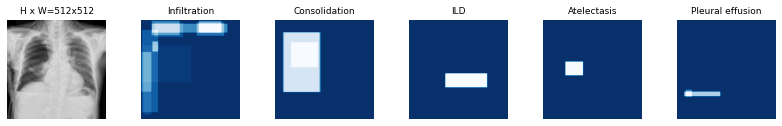

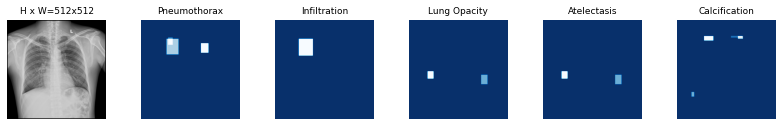

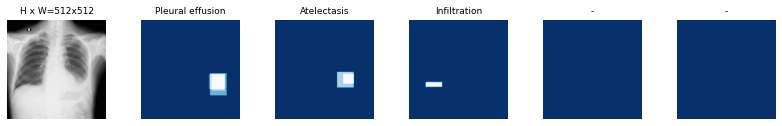

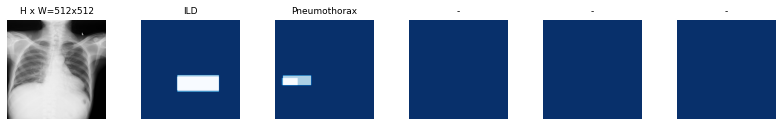

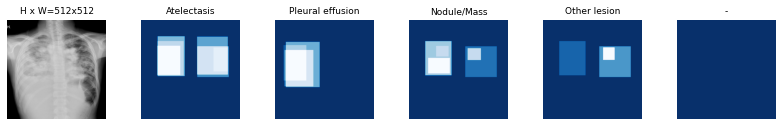

In [20]:
for i in range(0,5):
    image_id = random.choice(train_dataset.image_ids)
    # print(image_id)
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)

    
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

In [23]:
WEIGHT_PATH = '/home/daitran/Desktop/research/kaggle/VinBigData/weights/mask_rcnn_coco.h5'

In [24]:
LR = 1e-4
EPOCHS = 5

model = modellib.MaskRCNN(mode='training', config=config, model_dir="")

model.load_weights(WEIGHT_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
history = model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS,
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: diagnostic20210121T1105/mask_rcnn_diagnostic_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Time

### Plot history loss evolution

## Submission


In [25]:
model_path = '/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/diagnostic20210121T1105/mask_rcnn_diagnostic_0002.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 2


In [26]:
PREPROCESSING_TEST_DATA = "/home/daitran/Desktop/research/kaggle/VinBigData/test/"

In [27]:
class InferenceConfig(DiagnosticConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.5

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir="")


In [28]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon


# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width)).T

def annotations_to_mask(annotations, height, width):
    if isinstance(annotations, list):
        # The annotation consists in a list of RLE codes
        mask = np.zeros((height, width, len(annotations)))
        for i, rle_code in enumerate(annotations):
            mask[:, :, i] = decode_rle(rle_code, height, width)
    else:
        error_message = "{} is expected to be a list or str but received {}".format(annotation, type(annotation))
        raise TypeError(error_message)
    return mask

def find_anomalies(dicom_image, display=False):

    image_dimensions = dicom_image.shape

    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    saved_filename = PREPROCESSING_TEST_DATA+"temp_image.jpg"
    cv2.imwrite(saved_filename, resized_img)
    img = cv2.imread(saved_filename)

#     print(img)
    result = model.detect([img])
    r = result[0]

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'),
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']

    if display:
        visualize.display_instances(img, rois, masks, r['class_ids'],
                                    ['bg']+category_list, r['scores'],
                                    title="prediction", figsize=(12, 12))
    return rois, r['class_ids'], r['scores']

In [29]:
image_size=512
test_file_list = os.listdir(TEST_DIR)[1:10]

for test_file in test_file_list:
    dicom_image = dicom2array(TEST_DIR + '/' + test_file)
    find_anomalies(dicom_image, display=True)

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1_2/Conv2D}}]]
	 [[rpn_class_2/concat/_5489]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1_2/Conv2D}}]]
0 successful operations.
0 derived errors ignored.